# 변경 사항


* BiLSTM으로 변경.
* softmax 함수 겹치는 것 제거.
* custom_acc, custom_loss_func 도입. (사용 선택)
---
[005] weighted cross entropy 미적용.
* 005-1 | lr:0.0001 hidden layer: 4
* 005-1 | lr:0.00005 hidden layer: 4

[006] weighted cross entropy 적용.

# 0. 제반 환경 준비

In [ ]:
# 구글 드라이브 연결.
# from google.colab import drive
# drive.mount('/content/drive')

MODEL_PATH = '/model005.pt'

In [2]:
# 데이터처리 관련 라이브러리.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re  # 정규표현식 사용 환경 제공.
import string
from collections import Counter
# import seaborn as sns

# 자연어처리 관련 라이브러리.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# 딥러닝 관련 라이브러리.
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm  # .ipynb에 최적화된 프로그래스 바.
# from tqdm import tqdm

# 데이터셋 로딩용 라이브러리.
!pip install -q datasets

# LR sceduler 사용을 위한 hugging face의 transformers 설치.
!pip install -q transformers

# LR sceduler import.
from transformers import get_cosine_schedule_with_warmup

# Set pytorch random seed.
seed = 1210
torch.manual_seed(seed)
print("Random Seed:", seed)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Random Seed: 1210


# 1. Data 불러오기


In [3]:
# 데이터셋 로딩.
from datasets import load_dataset  # Huggingface의 datasets 라이브러리를 이용.

# Yelp Review Full 데이터셋 불러오기.
# 음식점, 서비스, 장소 등 비즈니스에 대한 텍스트 후기와 별점(0-4)이 포함된 데이터셋.
dataset_train = load_dataset("yelp_review_full", split="train")
dataset_test = load_dataset("yelp_review_full", split="test")

# 데이터셋의 예시 확인.
print(dataset_train)
for i in range(10):
    print(dataset_train[i])
print(dataset_test)
for i in range(10):
    print(dataset_test[i])

Dataset({
    features: ['label', 'text'],
    num_rows: 650000
})
{'label': 4, 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}
{'label': 1, 'text': "Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run in

In [4]:
# Pandas DataFrame 형태로 변환.
train_df = pd.DataFrame(dataset_train)
test_df = pd.DataFrame(dataset_test)

# train_df와 test_df를 하나의 DataFrame으로 세로로 연결.
data_df = pd.concat([train_df, test_df], ignore_index=True)


# Train data 65만개, Test data 5만개, 총 70만개, 별점 별 14만개.
# 별점 별 동일 개수.
data_count = [[data_df.label.value_counts()[0],
        data_df.label.value_counts()[1],
        data_df.label.value_counts()[2],
        data_df.label.value_counts()[3],
        data_df.label.value_counts()[4]]]
print("# of all data:", data_df.shape[0])
pd.DataFrame(data_count, index=["# of data"])

# of all data: 700000


,0,1,2,3,4
# of data,140000,140000,140000,140000,140000


# 2. Data 전처리

## 2-a. Data Cleaning.
unicode characters, puncutation, stopwords 제거.

In [5]:
def data_preprocessing(text):
    text = text.lower()
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", text) # Removing Unicode Characters
    text = ''.join([c for c in text if c not in string.punctuation]) # Remove punctuation

    # Removing Stopwords
    # stop words are common words within sentences that do not add value
    # and thus can be eliminated when cleaning for NLP prior to analysis.
    # e.g., 'the', 'was'

    stop_words = set(stopwords.words('english'))
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)

    return text

tqdm.pandas()  # tqdm을 이용하여 진행률 표시하기 위해 초기화.
data_df['cleaned_text'] = data_df['text'].progress_apply(data_preprocessing)  # cleaned_text 열을 생성하면서 진행률 표시.
data_df.head()

  0%|          | 0/700000 [00:00<?, ?it/s]

,label,text,cleaned_text
0,4,dr. goldberg offers everything i look for in a...,dr goldberg offers everything look general pra...
1,1,"Unfortunately, the frustration of being Dr. Go...",unfortunately frustration dr goldberg patient ...
2,3,Been going to Dr. Goldberg for over 10 years. ...,going dr goldberg 10 years think one 1st patie...
3,3,Got a letter in the mail last week that said D...,got letter mail last week said dr goldberg mov...
4,0,I don't know what Dr. Goldberg was like before...,know dr goldberg like moving arizona let tell ...


# 3. Data 토큰화

## 3-a. Create Vocab-Int mapping.

단어 추출 후, 빈도를 계산하여 순서대로 *sorted_words*에 저장.

In [6]:
corpus = [word for text in data_df['cleaned_text'] for word in text.split()]
count_words = Counter(corpus)
sorted_words = count_words.most_common()

Vocabulary 생성.
One-hot vectoer.

In [7]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

# tqdm을 사용하여 cleaned_text 열의 각 텍스트에 대한 진행률 표시.
text_int = []

# tqdm을 이용해 cleaned_text의 각 항목에 대해 진행률 표시.
for text in tqdm(data_df['cleaned_text'], desc="Converting text to integers"):
    r = [vocab_to_int[word] for word in text.split()]
    text_int.append(r)

# 첫 번째 텍스트의 정수 표현 확인.
print(text_int[:1])

# DataFrame에 정수 표현을 추가.
data_df['text_int'] = text_int

Converting text to integers:   0%|          | 0/700000 [00:00<?, ?it/s]

[[913, 38405, 1310, 105, 165, 1011, 13744, 21, 487, 630, 234, 9467, 53, 8, 880, 3516, 10242, 176, 1420, 2327, 40493, 1583, 994, 1390, 691, 85, 1654, 131, 3437, 6, 13831, 68, 13559, 234, 68, 34, 14, 131, 427, 258, 50, 1325, 14, 8373, 5381]]


# 4. Padding and Truncating the data

## 4-a. Analyze the text length

count    700000.000000
mean         70.655090
std          63.825577
min           0.000000
25%          28.000000
50%          52.000000
75%          92.000000
max        1002.000000
Name: text_len, dtype: float64


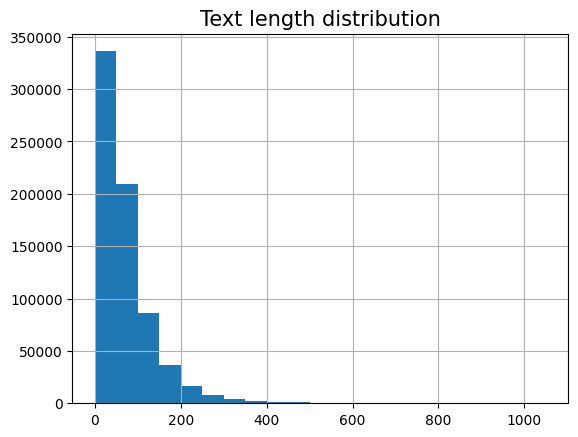

In [8]:
text_len = [len(x) for x in text_int]
data_df['text_len'] = text_len

print(data_df["text_len"].describe())

data_df["text_len"].hist(bins = range(min(data_df["text_len"]), max(data_df["text_len"]) + 50, 50))
plt.title('Text length distribution', size=15)
plt.show()

## 4-b. Padding / Truncation

In [9]:
def Padding(review_int, seq_len):
    '''
    0으로 패딩
    Return features of text_int, where each text is padded with 0's or truncated to the input seq_length.
    '''
    # Initialize the features array with zeros.
    features = np.zeros((len(review_int), seq_len), dtype=int)

    # tqdm을 사용하여 패딩 작업의 진행률 표시.
    for i, text in tqdm(enumerate(review_int), total=len(review_int), desc="Padding reviews"):
        if len(text) <= seq_len:
            zeros = list(np.zeros(seq_len - len(text)))
            new = text + zeros
        else:
            new = text[:seq_len]
        features[i, :] = np.array(new)

    return features

# seq_len 200으로 설정하고 Padding 함수 호출.
features = Padding(text_int, 200)
# print(features[0, :])

Padding reviews:   0%|          | 0/700000 [00:00<?, ?it/s]

# 5. Data split
test : valid : test = 12 : 1 : 1 비율로 dataset 분리.

In [10]:
# Train set 분리
X_train, X_remain, y_train, y_remain = train_test_split(features, data_df['label'].to_numpy(), test_size=1/7, random_state=1)

# Valid set, Test set 분리
X_valid, X_test, y_valid, y_test = train_test_split(X_remain, y_remain, test_size=0.5, random_state=1)

print("# of Train dataset:", len(X_train))
print("# of Valid dataset:", len(X_valid))
print("# of Test dataset:", len(X_test))

# of Train dataset: 600000
# of Valid dataset: 50000
# of Test dataset: 50000


# 6. Set hyperparameter

In [11]:
BATCH_SIZE = 64  # 16, 32, 64, 128 등 해보고 결과 비교.

EMBED_DIM = 64
HIDDEN_DIM = 256
N_LAYERS = 4
DROPOUT_PROB = 0.3  # 0.3 - 0.5 정도. 데이터셋이 많을 수록 작은 값 사용하는 편.

SEMI_DIFF_SCORE = 0.2  # predict label과 real label이 1만큼 차이 날 때, 몇 점으로 매길 것인지. 완전 불일치 0. 완전 일치 1.

VOCAB_SIZE = len(vocab_to_int) + 1  # 고정.
OUTPUT_SIZE = 5  # 고정.

# 7. Data loader

In [12]:
# trun our data into tensor dataset
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

# build dataloaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) # drop_last. 마지막 배치에서 데이터셋이 부족하면 무시.
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

# 8. Deep learning Model
RNN with BiLSTM

In [13]:
# GPU vs. CPU 선택.
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, use CPU")

GPU is available


In [14]:
# Model Block 정의
class LSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob):
        super().__init__()
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True, bidirectional=True)

        # Dropout and fully connected layer
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_size)
        # self.softmax = nn.Softmax(dim=1)  # Softmax for multi-class output

    def forward(self, x, hidden):
        batch_size = x.size(0)

        # Embedding and LSTM output
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        # Stack up LSTM outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # Dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # Apply softmax to output layer for multi-class classification
        # softmax_out = self.softmax(out)

        # Reshape to batch size
        # softmax_out = softmax_out.view(batch_size, -1, self.output_size)
        # softmax_out = softmax_out[:, -1]  # Select final time step's output

        # return softmax_out, hidden

        # Softmax 제거 버전.
        # Reshape to batch size
        out = out.view(batch_size, -1, self.output_size)
        out = out[:, -1]  # Select final time step's output

        return out, hidden

    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.n_layers*2, batch_size, self.hidden_dim)).to(device)  # *2 Bidirection 이므로
        c0 = torch.zeros((self.n_layers*2, batch_size, self.hidden_dim)).to(device)  # *2 Bidirection 이므로
        hidden = (h0, c0)
        return hidden


In [15]:
# Model 생성.
model = LSTM(VOCAB_SIZE, OUTPUT_SIZE, EMBED_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT_PROB)
model = model.to(device)

print(model)

LSTM(
  (embedding): Embedding(245119, 64)
  (lstm): LSTM(64, 256, num_layers=4, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)


# 9. Train the Model

## 9-a. 학습 준비

In [ ]:
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, alpha=1.0, exponent=2):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none')
        self.alpha = alpha
        self.exponent = exponent

    def forward(self, pred, target):
        # 기본 CrossEntropy 손실 계산 (각 샘플마다)
        ce_loss = self.cross_entropy(pred, target)
        
        # 예측 클래스 추출
        _, pred_classes = torch.max(pred, dim=1)
        
        # 예측 클래스와 실제 클래스의 차이 계산
        difference = torch.abs(pred_classes - target)
        
        # 비선형 가중치 적용 (차이에 대해 거듭제곱과 alpha 가중치 적용)
        weights = (self.alpha * (difference.float() ** self.exponent)).detach()
        
        # 가중치가 적용된 손실
        weighted_loss = ce_loss * weights
        
        # 평균 손실 반환
        return weighted_loss.mean()

In [ ]:
lr = 0.0001  # learning rate.
wd = 0.01  # weight decay.
loss_func = nn.CrossEntropyLoss()  # 다중 클래스 분류를 위한 손실 함수.
custom_loss_func = CustomLoss()    # 다중 클래스 분류를 위한 손실 함수. 가중치 고려.
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
clip = 5 # for ameliorating the exploding-gradient problem.
epochs = 15

total_steps = len(train_loader) * epochs
warmup_steps = int(0.15 * total_steps)  # 예: 15%를 warmup 단계로 설정

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

In [18]:
def acc(pred, label):
    # 각 샘플에 대해 가장 높은 확률을 가진 클래스를 예측 클래스로 변환
    _, pred_classes = torch.max(pred, dim=1)  # 예측 확률의 최대값 인덱스를 클래스 레이블로 변환
    correct = torch.sum(pred_classes == label).item()  # 예측이 실제 레이블과 일치하는 수를 계산
    return correct

In [19]:
def custom_acc(pred, label):
    # 각 샘플에 대해 가장 높은 확률을 가진 클래스를 예측 클래스로 변환
    _, pred_classes = torch.max(pred, dim=1)  # 예측 확률의 최대값 인덱스를 클래스 레이블로 변환

    # 예측과 실제 레이블 간의 차이를 계산
    difference = torch.abs(pred_classes - label)

    # 정확하게 일치하면 1, 1만큼 차이나면 0.3, 그 외에는 0 점수 부여
    scores = torch.where(difference == 0, 1.0, torch.where(difference == 1, SEMI_DIFF_SCORE, 0.0))

    # 전체 점수의 합계를 계산
    total_score = torch.sum(scores).item()

    return total_score

In [20]:
each_epoch_tr_loss,each_epoch_vl_loss = [],[]
each_epoch_tr_acc,each_epoch_vl_acc = [],[]
each_epoch_tr_custom_acc,each_epoch_vl_custom_acc = [],[]
each_epoch_lr = []
valid_loss_min = np.Inf

## 9-b. 학습

In [ ]:
for epoch in range(epochs):
    print("Epoch", epoch+1)

    ## TRAINING ##
    train_losses = []
    train_acc = 0.0
    train_custom_acc = 0.0
    model.train()  # 모델을 훈련 모드로 설정
    h = model.init_hidden(BATCH_SIZE)  # 초기 hidden state 설정

    print("Train Step")
    for inputs, labels in tqdm(train_loader):
        h = tuple([each.data for each in h])  # 이전 hidden state 데이터 유지

        inputs, labels = inputs.to(device), labels.to(device)  # GPU 또는 CPU로 이동

        model.zero_grad()
        output, h = model(inputs, h)

        # 손실 계산 및 역전파
        loss = loss_func(output, labels)  # ----------
        # loss = custom_loss_func(output, labels)
        loss.backward()
        train_losses.append(loss.item())

        # 정확도 계산
        accuracy = acc(output, labels)
        custom_accuracy = custom_acc(output, labels)
        train_acc += accuracy
        train_custom_acc += custom_accuracy

        # exploding gradient 문제를 예방
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        # LR scheduler를 사용한다면,
        scheduler.step()

    print("Valid Step")
    ## EVALUATION ##
    val_losses = []
    val_acc = 0.0
    val_custom_acc = 0.0
    model.eval()  # 모델을 평가 모드로 설정
    val_h = model.init_hidden(BATCH_SIZE)  # 초기 hidden state 설정

    for inputs_v, labels_v in tqdm(valid_loader):
        val_h = tuple([each.data for each in val_h])

        inputs_v, labels_v = inputs_v.to(device), labels_v.to(device)  # GPU 또는 CPU로 이동

        output_v, val_h = model(inputs_v, val_h)
        val_loss = loss_func(output_v, labels_v)  # ----------
        # val_loss = custom_loss_func(output_v, labels_v)

        val_losses.append(val_loss.item())

        accuracy = acc(output_v, labels_v)
        custom_accuracy = custom_acc(output_v, labels_v)
        val_acc += accuracy
        val_custom_acc += custom_accuracy

    # 평균 손실 및 정확도 계산
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)
    epoch_train_custom_acc = train_custom_acc / len(train_loader.dataset)
    epoch_val_custom_acc = val_custom_acc / len(valid_loader.dataset)

    # 손실 및 정확도 기록
    each_epoch_tr_loss.append(epoch_train_loss)
    each_epoch_vl_loss.append(epoch_val_loss)
    each_epoch_tr_acc.append(epoch_train_acc)
    each_epoch_vl_acc.append(epoch_val_acc)
    each_epoch_tr_custom_acc.append(epoch_train_custom_acc)
    each_epoch_vl_custom_acc.append(epoch_val_custom_acc)
    each_epoch_lr.append(scheduler.get_last_lr())

    # print(f'Epoch {epoch + 1}')
    print("learning rate:", scheduler.get_last_lr())
    print(f'train_loss : {epoch_train_loss:.4f} | val_loss : {epoch_val_loss:.4f}')
    print(f'train_accuracy : {epoch_train_acc * 100:.2f}% | val_accuracy : {epoch_val_acc * 100:.2f}%')
    print(f'train_custom_accuracy : {epoch_train_custom_acc * 100:.2f}% | val_custom_accuracy : {epoch_val_custom_acc * 100:.2f}%')

    # 검증 손실이 줄어들면 모델 저장
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), MODEL_PATH)
        print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(valid_loss_min, epoch_val_loss))
        valid_loss_min = epoch_val_loss

    print(25 * '==')

Epoch 1
Train Step


  0%|          | 0/9375 [00:00<?, ?it/s]

# 10. Test

In [ ]:
# Get test data loss and accuracy

test_losses = []  # track loss
num_correct = 0

# init hidden state
test_h = model.init_hidden(BATCH_SIZE)

model.eval()
# iterate over test data
for inputs, labels in tqdm(test_loader):

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    test_h = tuple([each.data for each in test_h])

    inputs, labels = inputs.to(device), labels.to(device)

    output, test_h = model(inputs, test_h)

    # calculate loss
    test_loss = loss_func(output, labels)  # CrossEntropyLoss는 logits을 사용하므로 squeeze하지 않음
    test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 to 4)
    pred = torch.argmax(output, dim=1)  # 가장 높은 확률을 가진 클래스 인덱스 선택

    # compare predictions to true label
    correct_tensor = pred.eq(labels.view_as(pred))  # 예측과 실제 라벨 비교
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

# -- stats! -- ##
# avg test loss
print("Test loss: {:.4f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct / len(test_loader.dataset)
print("Test accuracy: {:.2f}%".format(test_acc * 100))


In [ ]:
print(each_epoch_tr_loss)
print(each_epoch_vl_loss)
print(each_epoch_tr_acc)
print(each_epoch_vl_acc)
print(each_epoch_tr_custom_acc)
print(each_epoch_vl_custom_acc)
print(each_epoch_lr)

# 첫 번째 y축에 손실(loss)을 플로팅
fig, ax1 = plt.subplots()
ax1.plot(each_epoch_vl_loss, color='blue', marker='o', label="Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Validation Loss", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 두 번째 y축에 정확도(accuracy)를 플로팅
ax2 = ax1.twinx()
ax2.plot(each_epoch_vl_acc, color='red', marker='x', linestyle='--', label="Validation Accuracy")
ax2.set_ylabel("Validation Accuracy", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 제목 추가
plt.title(f"Validation Loss and Accuracy (lr: {lr}, hidden layer: {HIDDEN_DIM})")

# 그래프 표시
fig.tight_layout()  # 겹침 방지
plt.show()

## 10-append. 학습된 모델 불러오기.

In [ ]:
model.load_state_dict(torch.load(MODEL_PATH))